## Smoothing approaches

ADS surveys are very noisy because of inconsistent observation and variability among observers. A three-year sequence may have a lot of mortality, then nothing, then another spike. This probably isn't a real signal and makes it harder for the model to learn mortality dynamics. This notebook shows a few examples of how smoothing algorithms affect a mortality time series.

Prepare data

In [1]:
from scipy import signal, ndimage
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import rioxarray
import os
import skimage

if 'notebooks' in os.getcwd():
    os.chdir("..")

In [2]:
# Load
def preprocess_mortality(ds):
    year = os.path.basename(ds.encoding["source"])
    year = int(year.replace(".tif", ""))
    return ds.squeeze(drop=True)\
        .drop_vars("spatial_ref")\
        .rename(band_data="mortality")\
        .assign_coords(time=year)

damage = xr.open_mfdataset(
        "data_working/damage_rasters/*.tif",
        preprocess=preprocess_mortality,
        concat_dim="time", 
        combine="nested"
    ).compute()

In [3]:
damage

<xarray.Dataset> Size: 42MB
Dimensions:    (time: 27, y: 652, x: 590)
Coordinates:
  * x          (x) float64 5kB -1.389e+07 -1.389e+07 ... -1.154e+07 -1.154e+07
  * y          (y) float64 5kB 6.278e+06 6.274e+06 ... 3.678e+06 3.674e+06
  * time       (time) int64 216B 1997 1998 1999 2000 ... 2020 2021 2022 2023
Data variables:
    mortality  (time, y, x) float32 42MB nan nan nan nan nan ... nan nan nan nan

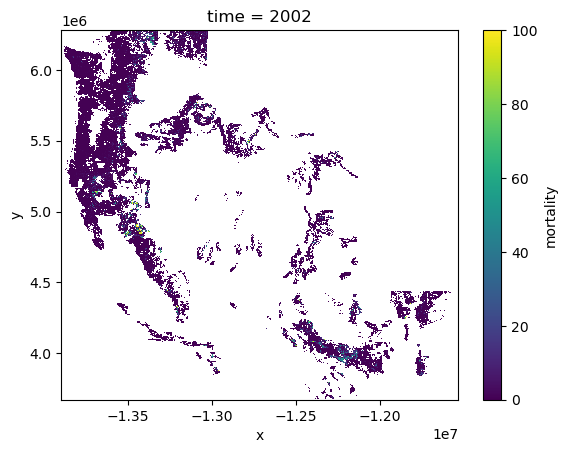

In [4]:
damage.mortality.isel(time=5).plot()

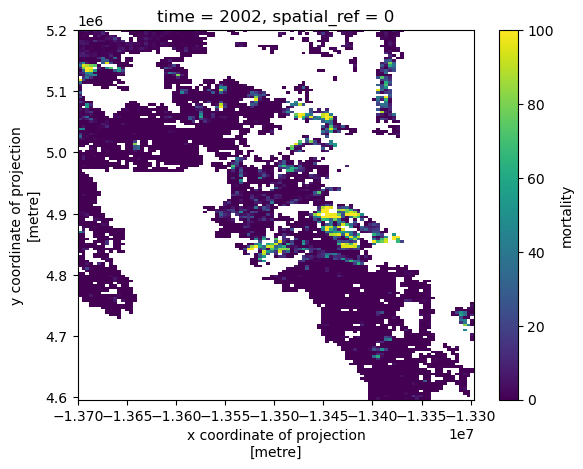

In [5]:
# Clip to CA where there seems to be more noise
sierra_nevada = (-1.37e7, 4.6e6, -1.33e7, 5.2e6)
damage_ca = damage.rio.write_crs(3857).rio.clip_box(*sierra_nevada)
damage_ca.mortality.isel(time=5).plot()

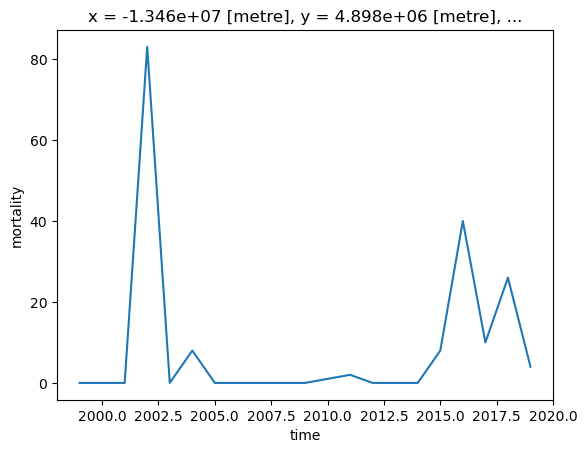

In [6]:
# Isolate a specific timeseries
ts_loc = dict(x=-1.346e7, y=4.9e6)
damage_ca.mortality.sel(**ts_loc, method="nearest").plot()

In [42]:
# Fill NAs with zero
damage_ca["mortality"] = damage_ca.mortality.fillna(0)

In [43]:
damage_ca.mortality.shape

(27, 151, 101)

In [44]:
# Apply a lowpass filter, clamp negatives to zero
b, a = signal.butter(4, 0.5, analog=False)
filtered = signal.filtfilt(b, a, damage_ca.mortality, axis=0)
filtered[filtered < 0] = 0
damage_ca["mortality_lowpass"] = (["time", "y", "x"], filtered)

In [45]:
# Apply a rolling ball filter to each timeseries
# N.b. this probably would not scale well
rb_kernel = skimage.restoration.ball_kernel(1, 1)
def do_rolling_ball(arr):
    arr_inv = 100 - arr
    return 100 - skimage.restoration.rolling_ball(arr_inv, kernel=rb_kernel)

damage_ca["mortality_rb"] = xr.apply_ufunc(
    do_rolling_ball,
    damage_ca.mortality,
    input_core_dims=[["time"]],
    output_core_dims=[["time"]],
    vectorize=True
)

In [46]:
def do_gaussian_filter(arr):
    return ndimage.gaussian_filter(arr, 1)

damage_ca["mortality_gauss_spatial"] = xr.apply_ufunc(
    do_gaussian_filter,
    damage_ca.mortality,
    input_core_dims=[["x", "y", "time"]],
    output_core_dims=[["x", "y", "time"]],
    vectorize=True
)

In [47]:
def do_1d_gaussian_filter(arr):
    return ndimage.gaussian_filter1d(arr, 1)

damage_ca["mortality_gauss_temporal"] = xr.apply_ufunc(
    do_gaussian_filter,
    damage_ca.mortality,
    input_core_dims=[["time"]],
    output_core_dims=[["time"]],
    vectorize=True
)

In [48]:
# Forwards-backwards exponentially weighted average 
# https://stackoverflow.com/questions/42869495/numpy-version-of-exponential
# -weighted-moving-average-equivalent-to-pandas-ewm

def numpy_ewma_vectorized(data, window):
    if np.all(np.isnan(data)):
        return data
    
    alpha = 2 /(window + 1.0)
    alpha_rev = 1-alpha

    scale = 1/alpha_rev
    n = data.shape[0]

    r = np.arange(n)
    scale_arr = scale**r
    first_non_nan = np.where(~np.isnan(data))[0][0]
    offset = data[first_non_nan]*alpha_rev**(r+1)
    pw0 = alpha*alpha_rev**(n-1)

    mult = data*pw0*scale_arr
    cumsums = np.nancumsum(mult)
    out = offset + cumsums*scale_arr[::-1]
    return out

damage_ca["mortality_ewma"] = xr.apply_ufunc(
    numpy_ewma_vectorized,
    damage_ca.mortality,
    input_core_dims=[["time"]],
    output_core_dims=[["time"]],
    vectorize=True,
    kwargs=dict(window=3)
)

In [52]:
def masked_1d_convolve(data, kernel, **kwargs):
    data_ma = np.ma.array(data, mask=np.isnan(data))
    conv = np.ma.convolve(data_ma, kernel, **kwargs)
    conv = conv.filled(np.nan)
    # Don't fill with new data
    conv[np.isnan(data)] = np.nan
    return conv

exp_kernel = np.exp(np.arange(3)) / np.sum(np.exp(np.arange(3)))

damage_ca["mortality_lagmean"] = xr.apply_ufunc(
    masked_1d_convolve,
    damage_ca.mortality,
    input_core_dims=[["time"]],
    output_core_dims=[["time"]],
    vectorize=True,
    kwargs=dict(kernel=exp_kernel, mode="same")
)

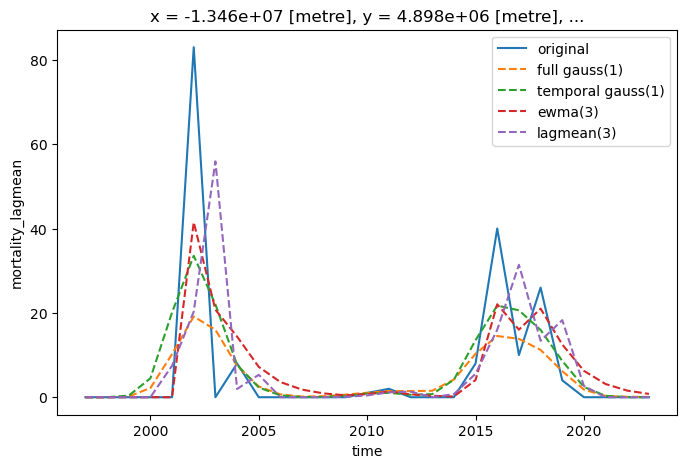

In [54]:
fig, ax = plt.subplots(figsize=(8, 5))
fmt = dict(linestyle='dashed')
damage_ca.sel(**ts_loc, method="nearest").mortality.plot(ax=ax, label="original")
#damage_ca.sel(**ts_loc, method="nearest").mortality_lowpass.plot(ax=ax, label="butter(4, 0.5)", **fmt)
#damage_ca.sel(**ts_loc, method="nearest").mortality_rb.plot(ax=ax, label="rollingball(1)", **fmt)
damage_ca.sel(**ts_loc, method="nearest").mortality_gauss_spatial.plot(ax=ax, label="full gauss(1)", **fmt)
damage_ca.sel(**ts_loc, method="nearest").mortality_gauss_temporal.plot(ax=ax, label="temporal gauss(1)", **fmt)
damage_ca.sel(**ts_loc, method="nearest").mortality_ewma.plot(ax=ax, label="ewma(3)", **fmt)
damage_ca.sel(**ts_loc, method="nearest").mortality_lagmean.plot(ax=ax, label="lagmean(3)", **fmt)


plt.legend()
plt.show()

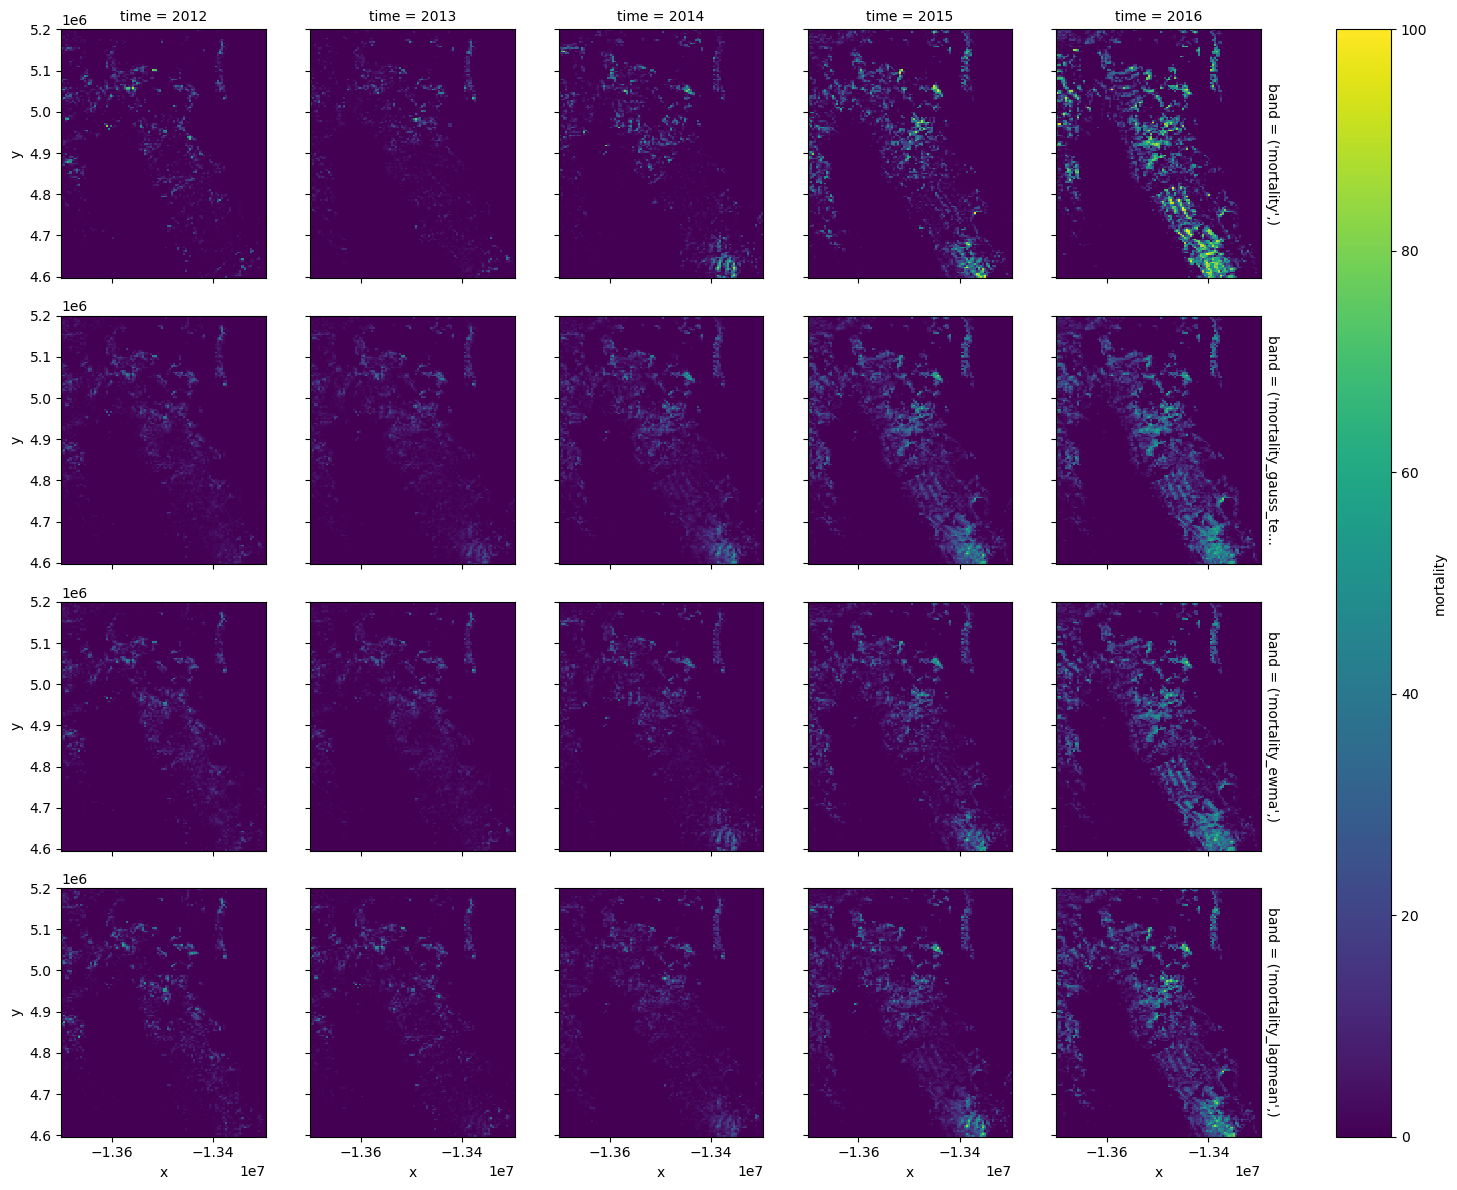

In [55]:
damage_ca[["mortality", "mortality_gauss_temporal", "mortality_ewma", "mortality_lagmean"]]\
    .to_stacked_array(new_dim="band", sample_dims=["x", "y", "time"])\
    .sel(time=slice(2012, 2016))\
    .plot(col="time", row="band")

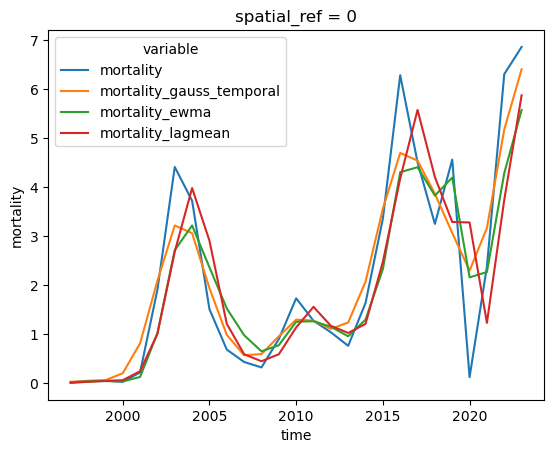

In [56]:
damage_ca[["mortality", "mortality_gauss_temporal", "mortality_ewma", "mortality_lagmean"]]\
    .to_stacked_array(new_dim="band", sample_dims=["x", "y", "time"])\
    .mean(dim=["x", "y"])\
    .plot.line(x="time", hue="variable")